# plot_SeaSurfAmpRatio

For modes

read data in netCDF file of modal amplitude at given vertical levels and plot the ratio


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = "serif"
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
from netCDF4 import Dataset, MFDataset
from xarray import open_mfdataset

from scipy.ndimage.filters import gaussian_filter
from itertools import product

krypton = "/data0/project/vortex/lahaye/"

In [2]:
grd_file = krypton+"lucky_corgrd.nc"
data_file = krypton+"DIAG/luckyt_SeaSurfModAmp_{}.?.nc"

cmap = "RdBu_r"

dosavefig = False

In [3]:
# load data
rat_win, rat_sum = {}, {}
nc = open_mfdataset(data_file.format("win"))
ncvar = nc.variables
xi = ncvar['xi_rho'].values
eta = ncvar["eta_rho"].values
lon = ncvar["lon_rho"].values
lat = ncvar["lat_rho"].values
topo = ncvar['h'].values
mode = ncvar['mode'].values
for key, val in ncvar.items():
    if key.startswith("ratio_"):
        rat_win[key.lstrip("ratio_")] = val.values
    elif key == "kred":
        k_win = val.values
nc.close()
nc = open_mfdataset(data_file.format("sum"))
for key, val in nc.variables.items():
    if key.startswith("ratio_"):
        rat_sum[key.lstrip("ratio_")] = val.values
    elif key == "kred":
        k_sum = val.values
nc.close()

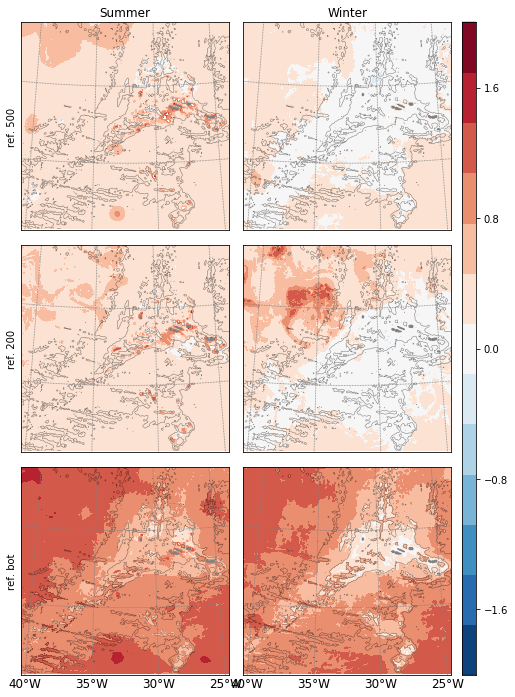

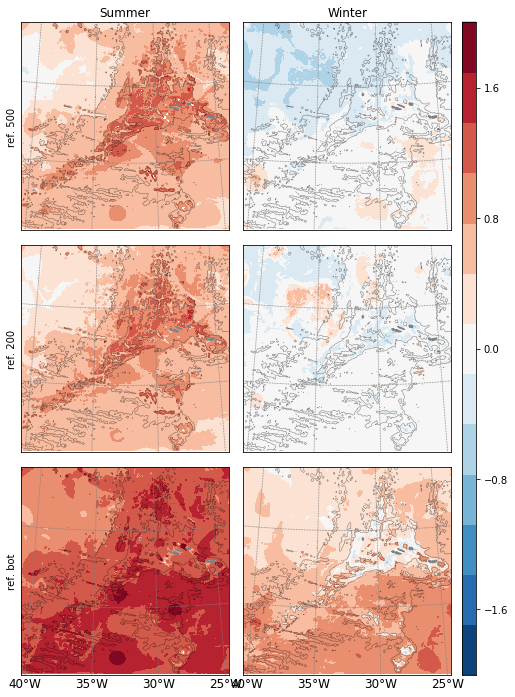

In [5]:
mods = [0,4] # None or "all" will do all, int will take int first, or list (or array)

vmin, vmax = -2, 2
levs = np.linspace(vmin, vmax, 14)
rat_typ = ["500", "200", "bot"]

cmap = "RdBu_r"
fs       = 12
proj     = 'lcc'
res      = 'i'
stride   = 5
Lx,Ly    = 1500e3,1500e3 # extend in km
grdcol = "grey"
zlevs=[0,2000,3500]

if isinstance(mods, int):
    mode = mode[mods]
elif isinstance(mods, (list, np.ndarray)):
    mode = mods
    
for imod in range(len(mode)):
    fig = plt.figure(figsize=(12,12))
    grid = ImageGrid(fig, 111, nrows_ncols=(len(rat_typ),2), share_all=True, cbar_location="right" \
                    , cbar_mode="single", cbar_pad=.15, axes_pad=.2, cbar_size=.2)
    for ityp in range(len(rat_typ)):
        if ityp==0:
            labs = [0, 1, 0, 0]
        elif ityp==len(rat_typ)-1:
            labs = [0, 0, 0, 1]
        else:
            labs = [0, 0, 0, 0]
        bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),
            lat_0=lat.mean(),width=Lx,height=Ly, ax=grid[ityp*2])
        xx, yy = bm(lon, lat)
        bm.drawcoastlines(color='gray')
        bm.fillcontinents(color='gray')
        bm.drawparallels(np.arange(-60,70,stride),labels=[0,0,1,0],linewidth=0.8,\
                    fontsize=fs,color=grdcol)
        bm.drawmeridians(np.arange(-100,100,stride),labels=labs,linewidth=0.8,\
                    fontsize=fs,color=grdcol)
        hct = bm.contour(xx,yy,topo,levels=zlevs,colors="k",linewidths=0.5,alpha=0.5)
        for item in hct.collections:
            item.set_rasterized(True)
        typ = rat_typ[ityp]
        hpc = bm.contourf(xx, yy, np.log10(rat_sum[typ][imod,:,:]), levels=levs \
                                     , cmap=cmap)
        for item in hpc.collections:
            item.set_rasterized(True)
        grid[ityp*2].set_ylabel("ref. "+typ)

        bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),
            lat_0=lat.mean(),width=Lx,height=Ly, ax=grid[ityp*2+1])
        bm.drawcoastlines(color='gray')
        bm.fillcontinents(color='gray')
        bm.drawparallels(np.arange(-60,70,stride),labels=[0,0,0,0],linewidth=0.8,\
                    fontsize=fs,color=grdcol)
        bm.drawmeridians(np.arange(-100,100,stride),labels=labs,linewidth=0.8,\
                    fontsize=fs,color=grdcol)
        hct = bm.contour(xx,yy,topo,levels=zlevs,colors="k",linewidths=0.5,alpha=0.5)
        for item in hct.collections:
            item.set_rasterized(True)
        hpc = bm.contourf(xx, yy, np.log10(rat_win[typ][imod,:,:]), levels=levs \
                                     , cmap=cmap)
        for item in hpc.collections:
            item.set_rasterized(True)
    grid[-1].cax.colorbar(hpc)

    grid[0].set_title('Summer')
    grid[1].set_title('Winter')

    if dosavefig:
        plt.savefig('pictures/luckyt_MapModAmpRatio_BothSeason_mod{:02d}.png'.format(mode[imod]) \
                    , magnification="auto", dpi=200, bbox_inches="tight")

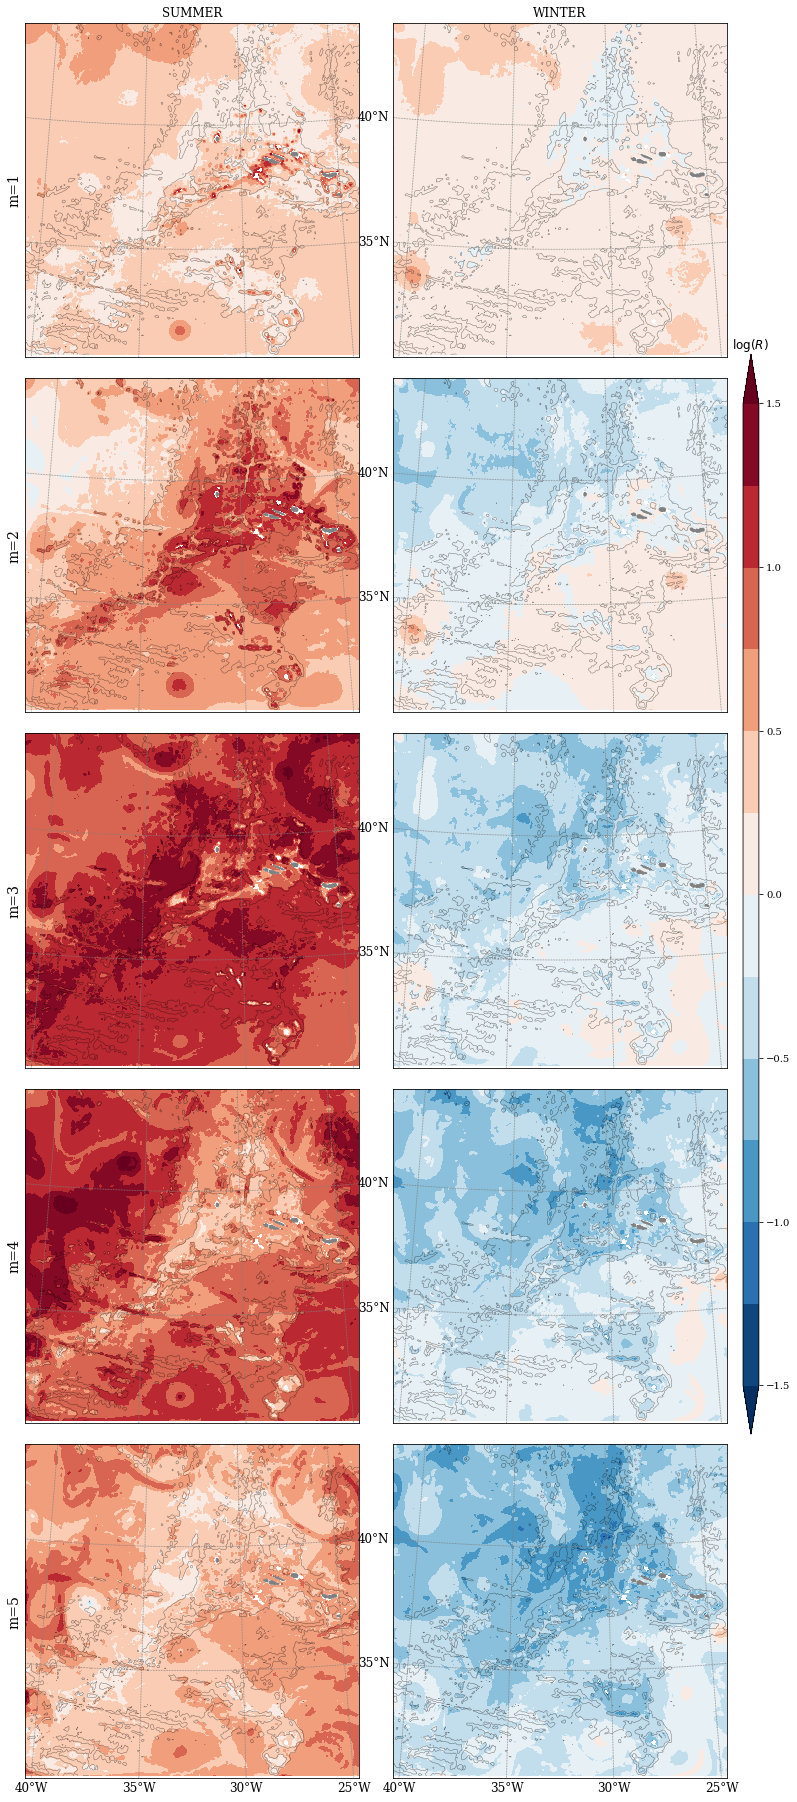

In [15]:
# plot for paper
zref = "500"
mods = np.arange(5)#[1,9] # None or "all" will do all, int will take int first, or list (or array)
labs = "abcd" # could use string.ASCII_letters instead

vmin, vmax = np.array([-1,1])*1.5
levs = np.linspace(vmin, vmax, 13)

cmap = "RdBu_r"
fs       = 12
proj     = 'lcc'
res      = 'i'
stride   = 5
Lx,Ly    = 1500e3,1500e3 # extend in km
grdcol = "grey"
zlevs=[0,2000,3500]
   
fig, axs = plt.subplots(len(mods),2,figsize=(11,len(mods)*5))

rats = [rat_sum[zref][mods,...], rat_win[zref][mods,...]]

for imod, isea in product(range(len(mods)),range(2)):
    ax = axs[imod,isea]
    bm = Basemap(projection=proj,resolution=res,lon_0=lon.mean(),
        lat_0=lat.mean(),width=Lx,height=Ly, ax=ax)
    xx, yy = bm(lon, lat)
    bm.drawcoastlines(color='gray')
    bm.fillcontinents(color='gray')
    labx, laby = int(imod==len(mods)-1), int(isea==1)
    bm.drawparallels(np.arange(-60,70,stride),labels=[laby,0,0,0],linewidth=0.8,\
                fontsize=fs,color=grdcol)
    bm.drawmeridians(np.arange(-100,100,stride),labels=[0,0,0,labx],linewidth=0.8,\
                fontsize=fs,color=grdcol)
    hct = bm.contour(xx,yy,topo,levels=zlevs,colors="k",linewidths=0.5,alpha=0.5)
    for item in hct.collections:
        item.set_rasterized(True)
    hpc = bm.contourf(xx, yy, np.log10(rats[isea][imod,:,:]), levels=levs \
                                 , cmap=cmap, extend="both")
    for item in hpc.collections:
        item.set_rasterized(True)
    if len(labs)>=2*len(mods):
        ax.text(.95, .95, labs[imod*2+isea], transform=ax.transAxes, bbox=dict(facecolor="w",edgecolor="k", pad=2), fontsize=13)

for imo,mod in enumerate(mods):
    axs[imo,0].set_ylabel(r'm={}'.format(mod+1), fontsize=14)
for ise,sea in enumerate(["summer","winter"]):
    axs[0,ise].set_title(sea.upper())
    
fig.tight_layout()

fig.subplots_adjust(right=0.9, wspace=.1)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
ac = plt.colorbar(hpc, cax=cbar_ax, extend="both")
ac.ax.set_title(r'$\log(R)$')

if dosavefig:
    fig.savefig('pictures/paper_figs/luckyt_MapModAmpRatio_BothSeason.png'.format(mode[imod]) \
                , magnification="auto", dpi=200, bbox_inches="tight")

(0.01, 100.0)

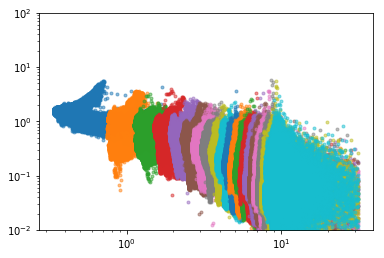

In [38]:
# try to plot all values
dosm = False
smwd = 3
indx, indy = np.where(topo>500)

rat = rat_win
kre = k_win

for imod in range(20):
    if dosm:
        myrat = gaussian_filter(rat['500'][imod,:,:], smwd)[indx,indy]
        kred = gaussian_filter(kre[imod,:,:], smwd)[indx,indy]
    else:
        myrat = rat['500'][imod,indx,indy]
        kred = kre[imod,indx,indy]
    plt.loglog(kred.ravel(), myrat.ravel(), '.', alpha=.5)
plt.ylim([1e-2, 1e2])

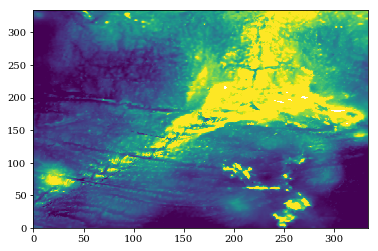

In [12]:
imod = 1
kplot = k_win[imod,:,:].real
vmin = np.nanmean(kplot)*0.8
vmax = np.nanmean(kplot)*1.2
plt.pcolormesh(kplot, vmin=vmin, vmax=vmax)


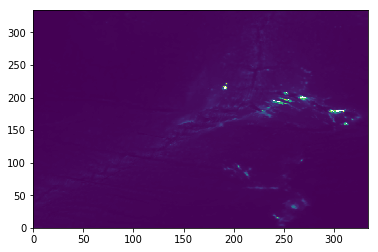

In [37]:
plt.pcolormesh(np.where(topo>100, 1./topo, np.nan))

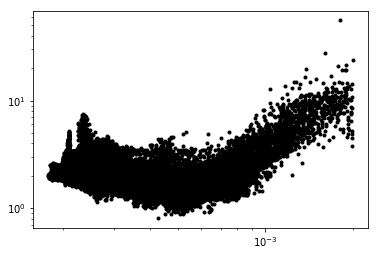

In [42]:
kred = 1./topo
rat = rat_sum['500'][0,:,:]
plt.loglog(kred, rat, '.k')

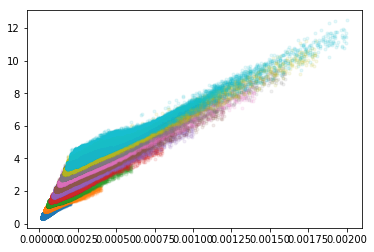

In [54]:
indx, indy = np.where(topo>500)
for imod in range(10):
    plt.plot((imod+1)/topo[indx,indy].ravel(), k_sum[imod,indx,indy].ravel(), '.', alpha=.1)

In [51]:
k_sum[2,indx,indy].min(), k_sum[2,indx,indy].max()

(1.0589509, 3.7710874)